## Chapter 5

### Blackjack

In [19]:
from blackjack import *
from mdp.learning import Algorithms, V
from chapter05.util import plot_values, plot_policy, SelectA

#### Watch some games with the dealer/player policies

In [2]:
agent = Player(env=Table())
for i in range(3):
    print('\n', f'Game {i}')
    episode = blackjack_episode(agent, pause=0.2, verbose=2)


 Game 0
Policy: Policy(name='hit below 20', strategy=<Strategy.off: 1>, v=V(t=0, γ=1.0, θ=0.0000010, Δ=1000.0000000), require_stable=False, ε=0.0, es=False, converged=False, changes=0, stable=1)
T(t=0, s=Vis(p=14, dt=6, ua=F), a=Turn(draw=h, role=p), r=0, rn=-1),
T(t=1, s=Vis(p=24, dt=6, ua=F), a=Turn(draw=s, role=p), r=-1, rn=0)
Result: Status.lose Reward: -1
(Player: 24 vs Dealer: 13)


 Game 1
Policy: Policy(name='hit below 20', strategy=<Strategy.off: 1>, v=V(t=0, γ=1.0, θ=0.0000010, Δ=1000.0000000), require_stable=False, ε=0.0, es=False, converged=False, changes=0, stable=2)
T(t=0, s=Vis(p=13, dt=10, ua=F), a=Turn(draw=h, role=p), r=0, rn=-1),
T(t=1, s=Vis(p=23, dt=10, ua=F), a=Turn(draw=s, role=p), r=-1, rn=0)
Result: Status.lose Reward: -1
(Player: 23 vs Dealer: 14)


 Game 2
Policy: Policy(name='hit below 20', strategy=<Strategy.off: 1>, v=V(t=0, γ=1.0, θ=0.0000010, Δ=1000.0000000), require_stable=False, ε=0.0, es=False, converged=False, changes=0, stable=3)
T(t=0, s=Vis(p=18,

#### Learn the state-value function for the player policy

##### Using averaged returns and Monte Carlo first state episodic

In [3]:
m = 750_000
agent = Player(env=Table(), π=default_policy(γ=1.0))

In [4]:
Q = Algorithms.mc_first_visit(episode=blackjack_episode, agent=agent, kwargs={}, n=m)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 750000/750000 [03:16<00:00, 3811.42it/s]


Using `best()` to select action-values.
Doc string: Max action-value.
ars_getter: CacheInfo(hits=0, misses=0, maxsize=16384, currsize=0)
avs_getter: CacheInfo(hits=0, misses=360, maxsize=16384, currsize=360)


Figure 5.1
___________________

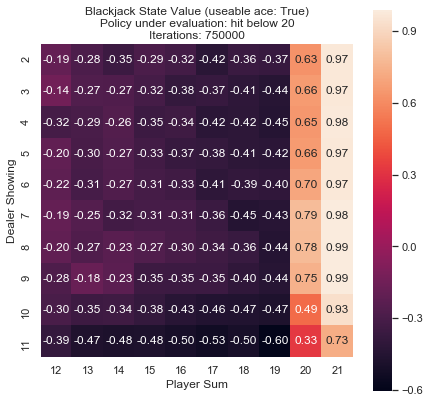

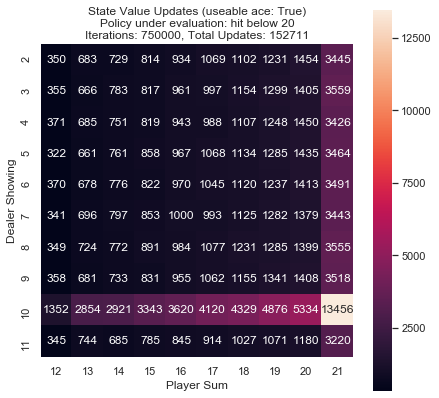

In [5]:
_ = plot_values(agent, Q, ace=True, f=2)

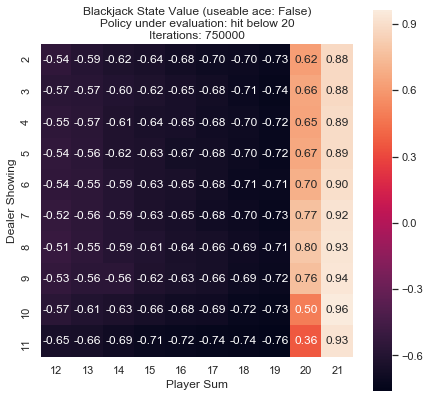

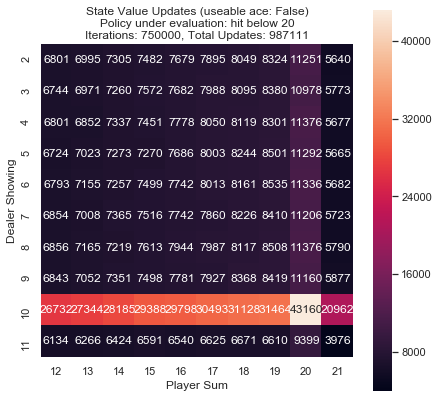

In [6]:
_ = plot_values(agent, Q, ace=False, f=2)

##### Action-values via Monte Carlo exploring start and random behavior policy

In [7]:
mc_exploring = Player(env=Table(), π=default_policy(γ=1.0))
mc_exploring.π.es = True
mc_exploring.π.strategy = Strategy.on
mc_exploring.π.select = SelectA.best

In [8]:
AQ = Algorithms.mc_exploring_starts(episode=blackjack_episode, agent=mc_exploring, kwargs={}, n=m)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 750000/750000 [03:03<00:00, 4078.38it/s]


ars_getter: CacheInfo(hits=0, misses=0, maxsize=16384, currsize=0)
avs_getter: CacheInfo(hits=563, misses=1271184, maxsize=16384, currsize=16384)


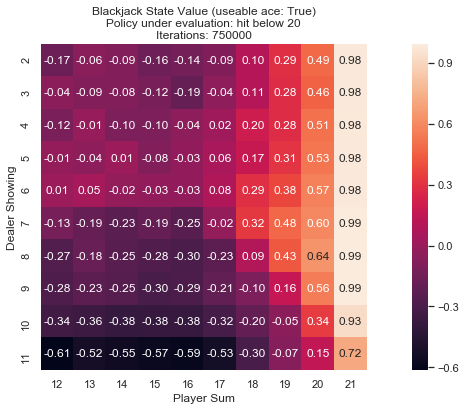

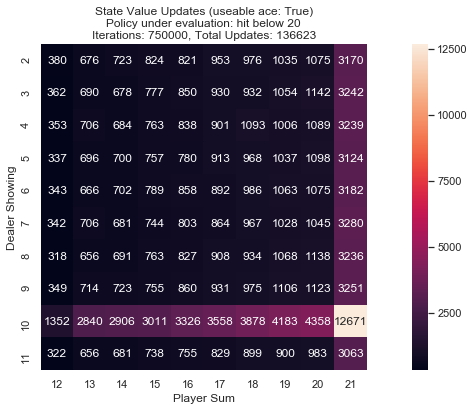

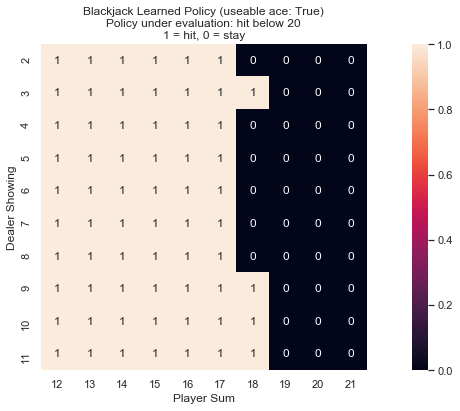

In [9]:
_ = plot_policy(mc_exploring, mc_exploring.π.v.r.Q, ace=True, f=2)

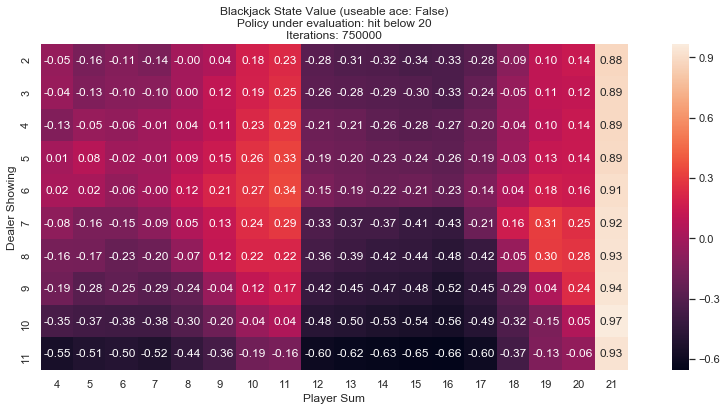

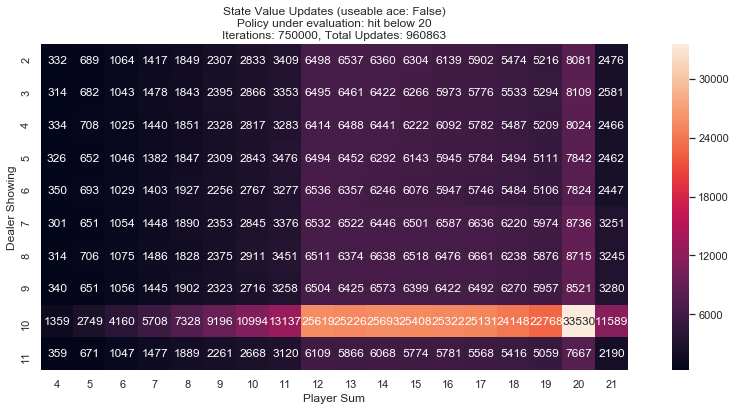

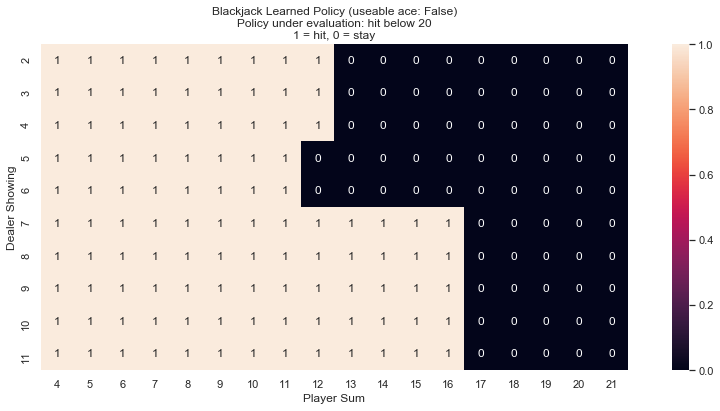

In [10]:
_ = plot_policy(mc_exploring, mc_exploring.π.v.r.Q, ace=False, f=2)

This policy and value function looks reasonable. There are a few differences from the book optimal result, not sure why.

##### Episodic value iteration

In [11]:
ep_value = Player(env=Table(), π=default_policy(γ=0.1))
ep_value.π.es = True
ep_value.π.strategy = Strategy.on
ep_value.π.select = SelectA.best

In [12]:
v = Algorithms.episodic_value_iteration(episode=blackjack_episode, agent=ep_value, kwargs={}, n=m)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 750000/750000 [03:52<00:00, 3228.81it/s]


ars_getter: CacheInfo(hits=238190, misses=1011290, maxsize=16384, currsize=16384)
avs_getter: CacheInfo(hits=563, misses=1271184, maxsize=16384, currsize=16384)


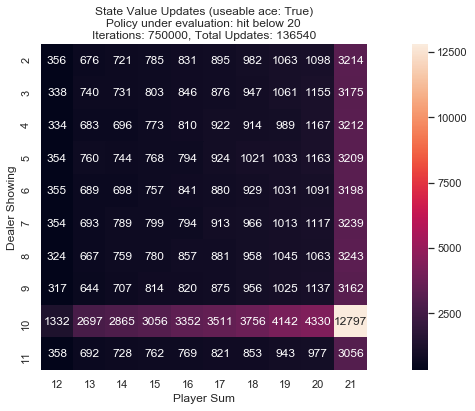

In [13]:
plot_policy(ep_value, ep_value.π.v.r.Q, values=True, ace=True, f=2)

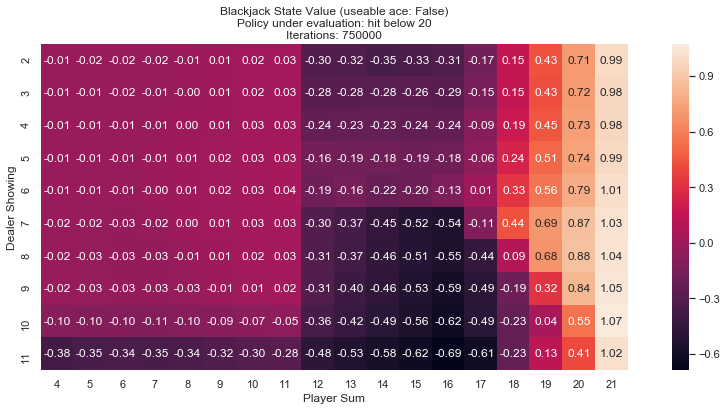

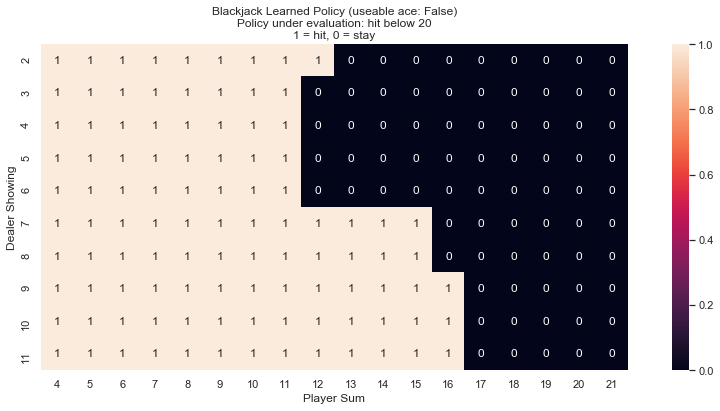

In [14]:
plot_policy(ep_value, ep_value.π.v.r.Q, values=True, ace=False, f=2)

This was just something I wanted to try, but it gets similar values and policy decisions to the MC approach. And as seen below, performs almost identically against the dealer.

#### MC on-policy first-visit control (ε-soft)

In [24]:
# note: epsilon is reduce logarithmically over time
m = 1_000_000
π = Policy(select=SelectA.best, ε=0.1, es=True, strategy=Strategy.ε_greedy, v=V(γ=1.0))
ε_agent = Player(env=Table(), π=π)

In [25]:
aQ = Algorithms.mc_on_policy_εgreedy(episode=blackjack_episode, agent=ε_agent, kwargs={}, n=m)
Q = ε_agent.π.v.r.Q

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [01:40<00:00, 9981.18it/s]


-------------------

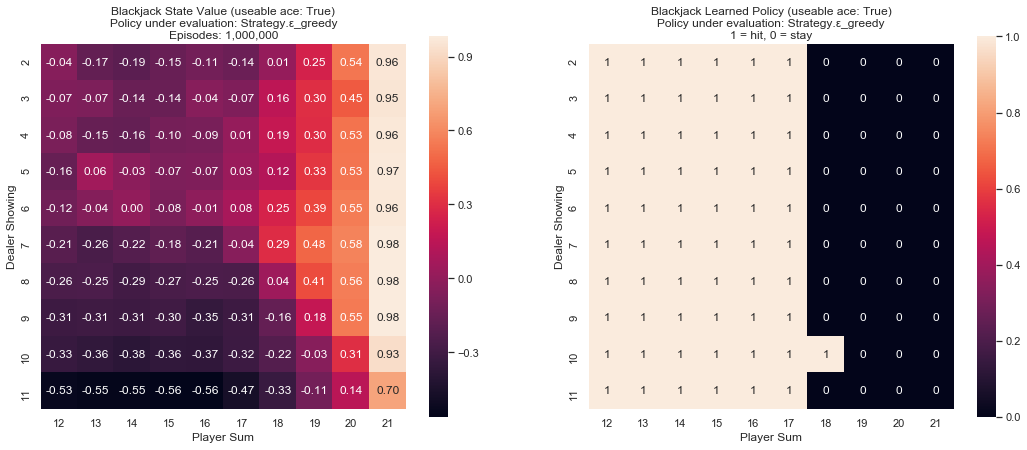

In [26]:
plot_policy(ε_agent, Q, ace=True, f=2)

-------------------

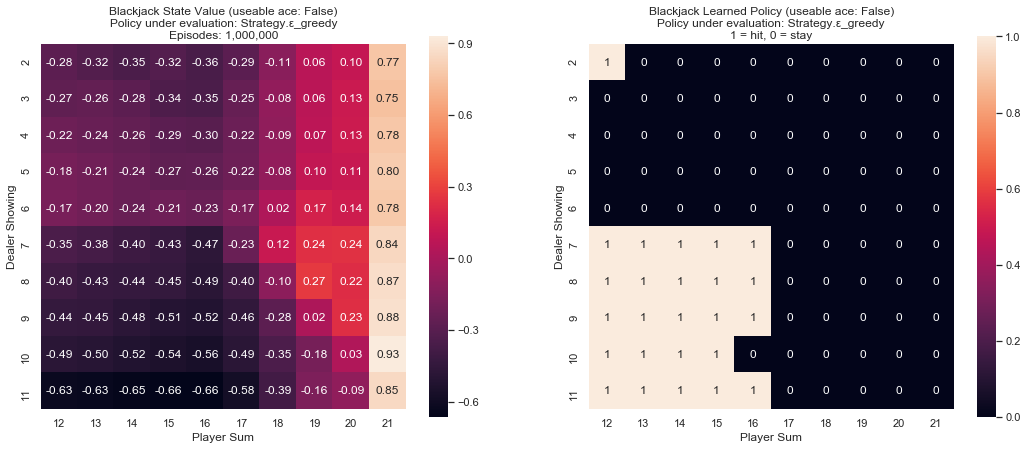

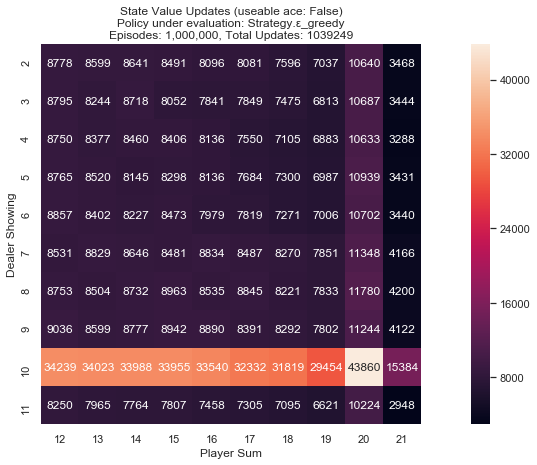

In [27]:
plot_policy(ε_agent, Q, ace=False, f=2)

### Compare win rates against the deterministic dealer policy

In [19]:
from tqdm import tqdm
results = {a: {1: 0, -1: 0, 0: 0} for a in ['mc', 'df', 'vl', 'εg']}
score = lambda episode: sum(s.rn for s in episode)
n = 50_000

In [20]:
# mc exploring
mc_exploring.π.es = False
mc_exploring.π.strategy = Strategy.on
for i in tqdm(range(n)):
    results['mc'][score(blackjack_episode(mc_exploring))] += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 6984.67it/s]


{'mc': {1: 21590, -1: 24013, 0: 4397},
 'df': {1: 0, -1: 0, 0: 0},
 'vl': {1: 0, -1: 0, 0: 0},
 'εg': {1: 0, -1: 0, 0: 0}}

In [21]:
# default (hit below 20) agent
for i in tqdm(range(n)):
    results['df'][score(blackjack_episode(Player(env=Table())))] += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:19<00:00, 2628.65it/s]


{'mc': {1: 21590, -1: 24013, 0: 4397},
 'df': {1: 15005, -1: 32495, 0: 2500},
 'vl': {1: 0, -1: 0, 0: 0},
 'εg': {1: 0, -1: 0, 0: 0}}

In [22]:
# episodic value iteration
ep_value.π.es = False
ep_value.π.strategy = Strategy.on
for i in tqdm(range(n)):
    results['vl'][score(blackjack_episode(ep_value))] += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 7026.98it/s]


{'mc': {1: 21590, -1: 24013, 0: 4397},
 'df': {1: 15005, -1: 32495, 0: 2500},
 'vl': {1: 21557, -1: 24132, 0: 4311},
 'εg': {1: 0, -1: 0, 0: 0}}

In [23]:
# mc ε-greedy agent
ε_agent.π.strategy = Strategy.on
for i in tqdm(range(n)):
    results['εg'][score(blackjack_episode(ε_agent))] += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:07<00:00, 7021.31it/s]


{'mc': {1: 21590, -1: 24013, 0: 4397},
 'df': {1: 15005, -1: 32495, 0: 2500},
 'vl': {1: 21557, -1: 24132, 0: 4311},
 'εg': {1: 21121, -1: 25035, 0: 3844}}

In [24]:
f_results = lambda key: f"win = {(results[key][1] / n):.1%}, tie = {(results[key][0] / n):.1%}, lose = {(results[key][-1] / n):.1%}"
print(f'Default Agent:    {f_results("df")}')
print(f'MC Explore Agent: {f_results("mc")}')
print(f'Episodic Value:   {f_results("vl")}')
print(f'MC ε-greedy:      {f_results("εg")}')

Default Agent:    win = 30.0%, tie = 5.0%, lose = 65.0%
MC Explore Agent: win = 43.2%, tie = 8.8%, lose = 48.0%
Episodic Value:   win = 43.1%, tie = 8.6%, lose = 48.3%
MC ε-greedy:      win = 42.2%, tie = 7.7%, lose = 50.1%


## Importance Sampling

### Example 5.4 (Blackjack)

In [4]:
import seaborn as sns

from chapter05.util import example_5_4

In [17]:
plotdf, data = example_5_4(max_ep=300_000)

episodes per iteration: 100, 272, 740, 2013, 5477, 14900, 40536, 110276, 300000


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [00:32<00:00, 9184.07it/s]


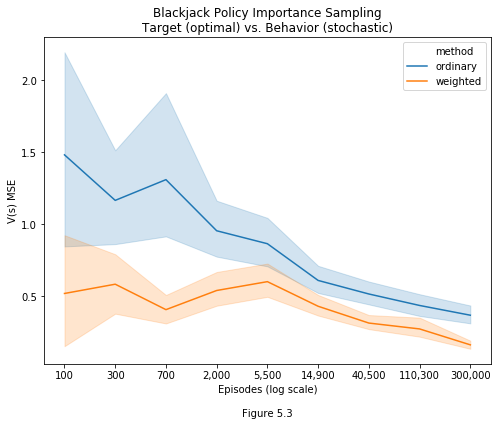

In [18]:
ax = sns.lineplot(x="episodes", y="mse", hue="method", data=plotdf.where(lambda x: x.method != "none"), sort=False)
ax.set_title("Blackjack Policy Importance Sampling\nTarget (optimal) vs. Behavior (stochastic)")
ax.set_xlabel("Episodes (log scale)\n\nFigure 5.3")
ax.set_ylabel("V(s) MSE")
ax.figure.set_size_inches((8, 6))

*Note: Episodes had random starts, so more are required to lower the error*